# <a id='toc1_'></a>[Natural Language Processing with Disaster Tweets](#toc0_)

Notebook for the Kaggle competition $\textit{Natural Language Processing with Disaster Tweets}$. Data consists of geolocated tweets, with a binary label indicating whether whether they're discussing a disaster.

We start by performing text pre-processing. We test different representation learning techniques, and then use extracted features to perform predictions with traditional classification models. Sections in the notebook relative to different embeddings are independent and may be readed separately. Also, they are highly overlapping in their pipeline, with the exception of Word2Vec, where we do not employ dimensionality reduction techniques.

In all cases presented below, we choose an L1-regularized logistic regression as our classifier. Despite its simplicity, this model turns out to be quite effective, well preventing overfitting and well treating the high dimensionality of the features space thanks to the enforced weight sparsity. Notwithstanding, deep learning models such as RNNs are known to perform better in the case of sequential data, such as speech. Such models would very likely improve the obtained performances.

We do not invest too much time investigating this route though. In the case at hand of a well defined classification task, the best performing strategy probably consists in fine tuning a transformer model. We do this in the notebook $\textit{Natural Language Processing with Disaster Tweets - ModernBERT}$. 

**Table of contents**<a id='toc0_'></a>    
- [Natural Language Processing with Disaster Tweets](#toc1_)    
  - [Data Loading and Inspection](#toc1_1_)    
    - [Descriptive stats](#toc1_1_1_)    
  - [Text preprocessing pipeline](#toc1_2_)    
  - [Read preprocessed](#toc1_3_)    
  - [One-hot encoding](#toc1_4_)    
  - [Bag of Words](#toc1_5_)    
  - [TF-IDF](#toc1_6_)    
  - [Word2Vec](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data Loading and Inspection](#toc0_)

In [ ]:
import pandas as pd
import numpy as np  
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.model_selection import train_test_split
import langdetect
from tqdm import tqdm
import pickle

In [ ]:
SUBMISSION_PATH = "submissions/"
MODEL_PATH = "models/"
DATA_PATH = "nlp_data/"

# List files
os.listdir(DATA_PATH)

['_preprocessed_data', 'test.csv', 'sample_submission.csv', 'train.csv']

In [4]:
# Read data
df_train = pd.read_csv(f"{DATA_PATH}train.csv")
print(df_train.info())
df_test = pd.read_csv(f"{DATA_PATH}test.csv")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [5]:
# Remove the id column
df_train = df_train.drop(columns=["id"])
test_ids = df_test["id"]
df_test = df_test.drop(columns=["id"])
df_train.sample(5)

,keyword,location,text,target
7026,typhoon,NaN,abcnews - Obama Declares Disaster for Typhoon-...,1
1580,cliff%20fall,Colchester Essex,I hope you fall off a cliff,0
1322,burning,NaN,Why put out a fire that's still burning?,0
3989,floods,Passamaquoddy,@ictyosaur I never thought it would be a wtf m...,1
5119,nuclear%20reactor,"Norwalk, CT",Has An Ancient Nuclear Reactor Been Discovered...,0


In [ ]:
# Fill all missing values with empty string
for df in [df_train,df_test]:
    for col in df.columns:
        df[col] = df[col].fillna("") 
        df[col] = df[col].astype(str)
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7613 non-null   object
 1   location  7613 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   object
dtypes: object(4)
memory usage: 238.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3263 non-null   object
 1   location  3263 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 76.6+ KB
None


### <a id='toc1_1_1_'></a>[Descriptive stats](#toc0_)

In [6]:
# Print occurrences of locations
loc_value_counts = df_train["location"].value_counts()
print("Number of unique locations:",len(loc_value_counts))
print("")   
for key,val in loc_value_counts.items():
    print(f"{key}: {val}")    

Number of unique locations: 3342

: 2533
USA: 104
New York: 71
United States: 50
London: 45
Canada: 29
Nigeria: 28
UK: 27
Los Angeles, CA: 26
India: 24
Mumbai: 22
Washington, DC: 21
Kenya: 20
Worldwide: 19
Australia: 18
Chicago, IL: 18
California: 17
New York, NY: 15
California, USA: 15
Everywhere: 15
Florida: 14
San Francisco: 14
United Kingdom: 14
Los Angeles: 13
Indonesia: 13
Washington, D.C.: 13
Ireland: 12
Toronto: 12
NYC: 12
Seattle: 11
San Francisco, CA: 11
Chicago: 11
Earth: 11
New York City: 10
London, UK: 10
Sacramento, CA: 10
Texas: 10
London, England: 10
Atlanta, GA: 10
ss: 10
US: 9
Denver, Colorado: 9
World: 9
Manchester: 9
304: 9
Dallas, TX: 9
San Diego, CA: 9
Nashville, TN: 9
South Africa: 8
Scotland: 8
Houston, TX: 8
Sydney: 7
Tennessee: 7
Pennsylvania, USA: 7
Austin, TX: 7
Denver, CO: 7
Memphis, TN: 7
worldwide: 7
Seattle, WA: 7
Orlando, FL: 6
Morioh, Japan: 6
Pedophile hunting ground: 6
Calgary, Alberta: 6
Singapore: 6
Brooklyn, NY: 6
Atlanta: 6
California, United Sta

In [7]:
# Print number of unique keywords
kw_value_counts = df_train["keyword"].value_counts()
print("Number of unique keywords:",len(kw_value_counts))
print("")

# Print number of unique words
split_text = df_train["text"].str.split(" ")
unique_words = set()
for text in split_text:
    unique_words.update(text)   
print("Number of unique words:", len(unique_words))

Number of unique keywords: 222

Number of unique words: 32017


In [8]:
for key,value in kw_value_counts.items():
    print(f"{key}: {value}")

: 61
fatalities: 45
deluge: 42
armageddon: 42
damage: 41
body%20bags: 41
harm: 41
sinking: 41
evacuate: 40
outbreak: 40
fear: 40
siren: 40
windstorm: 40
collided: 40
twister: 40
hellfire: 39
famine: 39
flames: 39
weapon: 39
wreckage: 39
sunk: 39
explosion: 39
earthquake: 39
collision: 39
derailment: 39
sinkhole: 39
wrecked: 39
weapons: 39
whirlwind: 39
bombed: 38
deaths: 38
typhoon: 38
fire: 38
injury: 38
fatal: 38
explode: 38
oil%20spill: 38
hurricane: 38
upheaval: 38
blaze: 38
flooding: 38
thunder: 38
ambulance: 38
derailed: 38
drowned: 38
panic: 37
hostages: 37
curfew: 37
crush: 37
destroy: 37
debris: 37
burning%20buildings: 37
bioterror: 37
sandstorm: 37
wreck: 37
wounded: 37
ruin: 37
fatality: 37
pandemonium: 37
mudslide: 37
police: 37
quarantined: 37
emergency: 37
blizzard: 37
devastation: 36
catastrophe: 36
refugees: 36
screaming: 36
tragedy: 36
desolation: 36
danger: 36
attack: 36
dust%20storm: 36
ablaze: 36
cliff%20fall: 36
detonate: 36
evacuation: 36
evacuated: 36
massacre: 3

<Axes: ylabel='Count'>

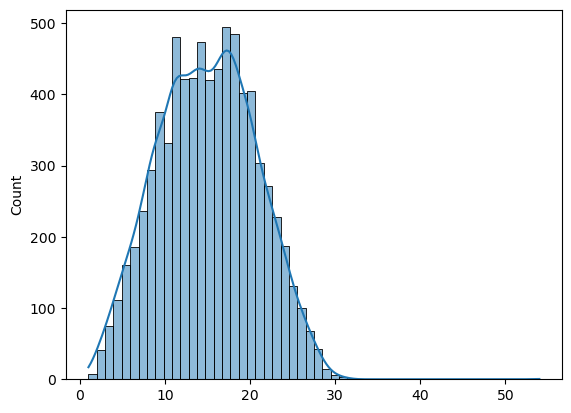

In [9]:
# Plot distribution of tweet length
tweet_lenghts = [len(text) for text in split_text]
sns.histplot(tweet_lenghts,kde=True,bins=max(tweet_lenghts))

In [10]:
tqdm.pandas()

# Print occurrencies of detected langugages
detected_langs = df_train['text'].progress_apply(lambda x: langdetect.detect(x))
lang_value_counts = Counter(detected_langs)
print("Language counts:", lang_value_counts)   

100%|██████████| 7613/7613 [00:22<00:00, 331.65it/s]

Language counts: Counter({'en': 7309, 'de': 57, 'it': 23, 'ca': 23, 'af': 22, 'da': 21, 'fr': 19, 'no': 17, 'nl': 16, 'sv': 13, 'et': 12, 'id': 11, 'tl': 10, 'cy': 8, 'ro': 8, 'es': 7, 'so': 6, 'vi': 5, 'pl': 5, 'sl': 4, 'fi': 4, 'pt': 4, 'sq': 3, 'hr': 2, 'sw': 2, 'lt': 1, 'tr': 1})


In [11]:
# Check class imbalance
Counter(df_train["target"])

Counter({'0': 4342, '1': 3271})

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis=1), df_train['target'], test_size=0.2, random_state=4)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
X_test = df_test.copy()
print("Train shape:", X_train.shape)    
print("Validation shape:", X_val.shape) 
print("Test shape:", X_test.shape)

Train shape: (6090, 3)
Validation shape: (1523, 3)
Test shape: (3263, 3)


## <a id='toc1_2_'></a>[Text preprocessing pipeline](#toc0_)

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string  
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
import urllib
from geotext import GeoText
import pickle

nltk.download('stopwords')          
nltk.download('wordnet')  
nltk.download('punkt') 
nltk.download('punkt_tab')

import nltk.data
nltk.data.path.append('/home/piero/nltk_data')

[nltk_data] Downloading package stopwords to /home/piero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/piero/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/piero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/piero/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# A class for the preprocessing pipeline which can be reused & adapted for several documents
# Thanks Petra!

class PreprocessingPipeline:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()    # lemmatization is the process of converting a word to its dictionary form
        self.stemmer = PorterStemmer()           # stemming is the process of reducing a word to its root form
        self.punctuation = string.punctuation

    # Translate into english
    def translate(self, text):  
        # Detect language
        try:
            lang = langdetect.detect(text)
        except Exception as e:
            print(f"Language detection error: {e}")
            return text
        
        # Translate to English if not already in English
        if lang != 'en':
            try:
                return GoogleTranslator(source=lang, target='en').translate(text)
            except Exception as e:
                print(f"Translation error: {e}")
                return ""
        else:
            return text
    
    #Converting text into tokens
    def tokenize(self, text):
        return word_tokenize(text)
    
    #Converting the tokens to lowercase
    def case_fold(self, token):
        return token.lower()
    
    #Removing stop-words
    def remove_stop_words(self, token):
        if token is not None and token not in self.stop_words:
            return token
        return None

    #Removing unwanted characters
    def remove_unwanted_characters(self, token):
        if token is not None and not token.isalpha():
            return None
        return token
    
    #Lemmatizing tokens
    def lemmatize(self,token):
        lemmatized_token = self.lemmatizer.lemmatize(token)
        return lemmatized_token
   
    def stem(self,token):
        stemmed_token = self.stemmer.stem(token)
        return stemmed_token

    #Preprocessing text by applying all steps from above
    def preprocess_text(self, text, translate=True,stem=False):
        """Returns a list of preprocessed tokens from the input text."""
        if not text:
            return []
        if not isinstance(text,str):
            return []
        if translate:
            text = self.translate(text)
        tokens = self.tokenize(text)
        preprocessed_tokens = []
        for token in tokens:
            token = self.case_fold(token)
            token = self.remove_stop_words(token)
            token = self.remove_unwanted_characters(token)
            
            if token is not None:
                token = self.lemmatize(token)
                if stem:
                    token = self.stem(token)
                preprocessed_tokens.append(token)
        
        return preprocessed_tokens

In [15]:
preprocessor = PreprocessingPipeline()

# Example of a non english text
text_ = "Il solito cassetto della miseria...§!!!##$%&/()=?"
text_ = preprocessor.preprocess_text(text_,translate=True,stem=False)
print(text_)

['usual', 'drawer', 'misery']


In [ ]:
# Add a translated column to the dfs
X_train["text_translated"] = X_train["text"].progress_apply(lambda x: preprocessor.translate(x))
X_val["text_translated"] = X_val["text"].progress_apply(lambda x: preprocessor.translate(x)) 
X_test["text_translated"] = X_test["text"].progress_apply(lambda x: preprocessor.translate(x)) 

# Add a preprocessed lemmatized column to the dfs
X_train["text_preprocessed_lemm"] = X_train["text_translated"].progress_apply(lambda x: preprocessor.preprocess_text(x))
X_val["text_preprocessed_lemm"] = X_val["text_translated"].progress_apply(lambda x: preprocessor.preprocess_text(x))
X_test["text_preprocessed_lemm"] = X_test["text_translated"].progress_apply(lambda x: preprocessor.preprocess_text(x))

# Display sample
display(X_train["text_preprocessed_lemm"].sample(5))

 87%|████████▋ | 5293/6090 [01:44<00:23, 33.91it/s] 

Translation error: @Blizzard_Gamin ight --> No translation was found using the current translator. Try another translator?


  7%|▋         | 441/6090 [00:09<01:05, 86.85it/s] 

Language detection error: No features in text.


 81%|████████▏ | 4956/6090 [01:22<00:18, 62.57it/s] 

Language detection error: No features in text.


 84%|████████▎ | 5086/6090 [01:27<00:44, 22.36it/s]

Language detection error: No features in text.


100%|██████████| 3263/3263 [01:32<00:00, 35.39it/s] 


538     [drafted, avalanche, rd, overall, played, last...
5322    [element, freedom, biggest, party, summer, mir...
7065    [indepth, look, new, world, work, young, peopl...
2776    [health, newyear, anniversary, devastation, wr...
3556    [russian, crematorium, provoke, outrage, amid,...
Name: text_preprocessed_lemm, dtype: object

In [17]:
def urllib_decode(text):
    """Decode text with urllib"""
    if not text:
        return text
    try:
        return urllib.parse.unquote(text)
    except Exception as e:
        print(f"Decoding error for <{text}>: {e}")
        return text

# Now keywords. First decode
X_train["keyword_decoded"] = X_train["keyword"].progress_apply(lambda x: urllib_decode(x))
X_val["keyword_decoded"] = X_val["keyword"].progress_apply(lambda x: urllib_decode(x))
X_test["keyword_decoded"] = X_test["keyword"].progress_apply(lambda x: urllib_decode(x))

# Lemmatize
X_train["keyword_preprocessed_lemm"] = X_train["keyword_decoded"].progress_apply(lambda x: preprocessor.preprocess_text(x,translate=False))
X_val["keyword_preprocessed_lemm"] = X_val["keyword_decoded"].progress_apply(lambda x: preprocessor.preprocess_text(x,translate=False))
X_test["keyword_preprocessed_lemm"] = X_test["keyword_decoded"].progress_apply(lambda x: preprocessor.preprocess_text(x,translate=False))

# Display sample
display(X_train["keyword_preprocessed_lemm"].sample(5))

100%|██████████| 3263/3263 [00:00<00:00, 20693.93it/s]


1124          [bombed]
6800         [tragedy]
85          [accident]
4021    [forest, fire]
5693         [rescued]
Name: keyword_preprocessed_lemm, dtype: object

In [18]:
def extract_country(location):
    if not location:
        return location
    places = GeoText(str(location)) 
    return places.countries[0] if places.countries else ""

# Now locations. First try geotext
X_train['location_gt'] = X_train['location'].progress_apply(extract_country)
X_val['location_gt'] = X_val['location'].progress_apply(extract_country)
X_test['location_gt'] = X_test['location'].progress_apply(extract_country)

# Lemmatize
X_train["location_preprocessed_lemm"] = X_train["location"].progress_apply(lambda x: preprocessor.preprocess_text(x,translate=False))
X_val["location_preprocessed_lemm"] = X_val["location"].progress_apply(lambda x: preprocessor.preprocess_text(x,translate=False))
X_test["location_preprocessed_lemm"] = X_test["location"].progress_apply(lambda x: preprocessor.preprocess_text(x,translate=False))

# Display sample
display(X_train["location_preprocessed_lemm"].sample(5))

100%|██████████| 3263/3263 [00:00<00:00, 21271.33it/s]


6086    [sacramento]
6628              []
3993      [michigan]
4328              []
6914       [atlanta]
Name: location_preprocessed_lemm, dtype: object

In [19]:
loc_value_counts = Counter(X_train["location_gt"])
print(len(loc_value_counts))
print(loc_value_counts)

84
Counter({'': 5554, 'Canada': 59, 'United States': 52, 'Australia': 40, 'Nigeria': 36, 'India': 34, 'Ireland': 19, 'United Kingdom': 18, 'Kenya': 16, 'Indonesia': 14, 'South Africa': 13, 'Georgia': 12, 'Philippines': 12, 'Spain': 11, 'Japan': 11, 'Germany': 9, 'Pakistan': 8, 'France': 8, 'Singapore': 7, 'China': 6, 'New Zealand': 6, 'Malaysia': 6, 'Sweden': 5, 'Jersey': 5, 'Jamaica': 5, 'Portugal': 5, 'Finland': 5, 'Puerto Rico': 5, 'Venezuela': 4, 'Switzerland': 4, 'Argentina': 4, 'Italy': 4, 'Brazil': 4, 'Norway': 3, 'Hong Kong': 3, 'Saudi Arabia': 3, 'Iraq': 3, 'Netherlands': 3, 'Israel': 3, 'Thailand': 3, 'Colombia': 3, 'Egypt': 3, 'Ukraine': 3, 'Somalia': 3, 'Belgium': 2, 'Maldives': 2, 'Mongolia': 2, 'Lebanon': 2, 'Greece': 2, 'Jordan': 2, 'Romania': 2, 'Chile': 2, 'Vietnam': 2, 'Afghanistan': 2, 'Russia': 2, 'Peru': 2, 'Honduras': 2, 'Kuwait': 2, 'Ecuador': 2, 'Uganda': 2, 'Haiti': 1, 'Antarctica': 1, 'Cyprus': 1, 'Zimbabwe': 1, 'Poland': 1, 'Macedonia': 1, 'Ghana': 1, 'Urugua

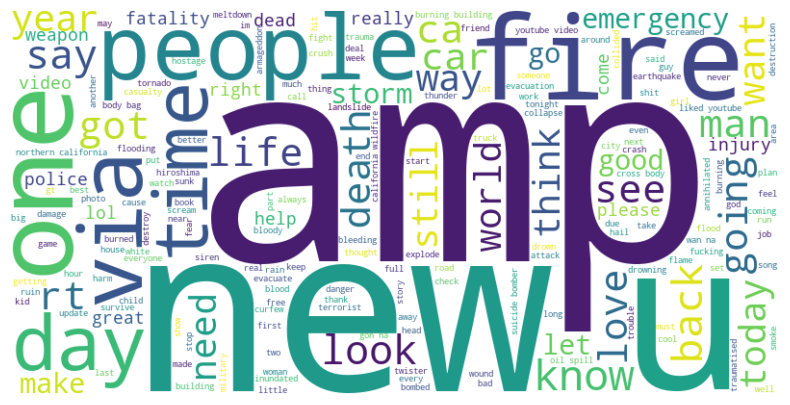

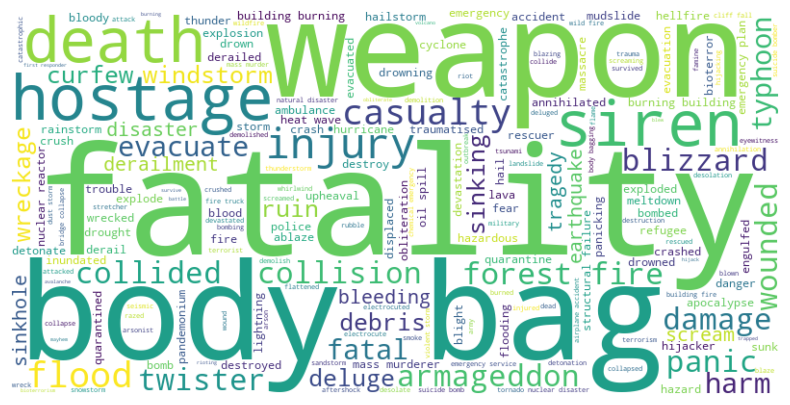

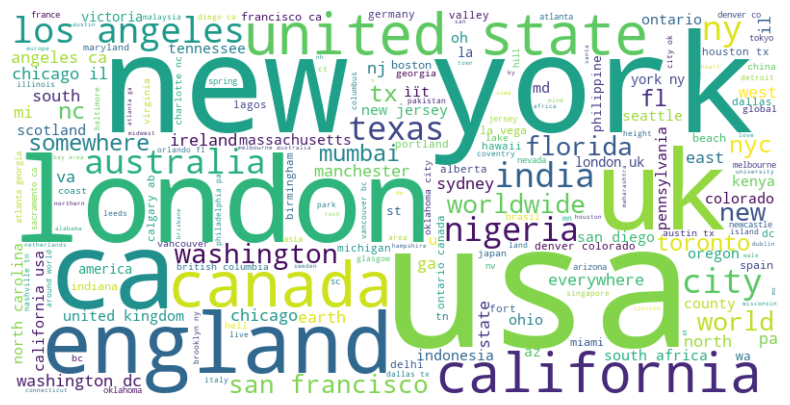

In [20]:
def plot_word_cloud(text):
    text = " ".join(text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot word cloud for the training set text
plot_word_cloud(X_train["text_preprocessed_lemm"].sum())

# Plot word cloud for the training set keywords
plot_word_cloud(X_train["keyword_preprocessed_lemm"].sum())

# Plot word cloud for the training set locations
plot_word_cloud(X_train["location_preprocessed_lemm"].sum())

In [ ]:
# Save
with open(f"{DATA_PATH}_preprocessed_data",'wb') as f:
    pickle.dump([X_train,X_val,X_test,y_train,y_val,test_ids],f)

## <a id='toc1_3_'></a>[Read preprocessed](#toc0_)

In [7]:
# Read
with open(f"{DATA_PATH}_preprocessed_data",'rb') as f:
    preprocessed_data = pickle.load(f)

In [8]:
X_train,X_val,X_test,y_train,y_val,test_ids = preprocessed_data

In [ ]:
print(X_train.info())
print("")
print(X_val.info())
print("")
print(X_test.info())
print("")
print(y_train.info())
print("")
print(y_val.info())
print("")
print(test_ids.info())
print("")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 6383 to 1146
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   keyword                     6090 non-null   object
 1   location                    6090 non-null   object
 2   text                        6090 non-null   object
 3   text_translated             6090 non-null   object
 4   text_preprocessed_lemm      6090 non-null   object
 5   keyword_decoded             6090 non-null   object
 6   keyword_preprocessed_lemm   6090 non-null   object
 7   location_gt                 6090 non-null   object
 8   location_preprocessed_lemm  6090 non-null   object
dtypes: object(9)
memory usage: 475.8+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 7239 to 5640
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   k

## <a id='toc1_4_'></a>[One-hot encoding](#toc0_)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

In [26]:
# Select preprocessed columns
preprocessed_lem_cols = ["text_preprocessed_lemm","keyword_preprocessed_lemm","location_preprocessed_lemm"]
X_train[preprocessed_lem_cols].head()

,text_preprocessed_lemm,keyword_preprocessed_lemm,location_preprocessed_lemm
6383,"[old, pkk, suicide, bomber, detonated, bomb, t...","[suicide, bomb]",[]
1189,"[two, crane, restoring, bridge, central, dutch...","[bridge, collapse]",[]
6288,"[happy, birthday, miss, much, amp, hope, great...",[storm],"[desert, storm]"
4546,"[michaelgbaron, come, scott, rice, get, anothe...",[injured],[]
6847,"[nissannews, trauma, alert, child, among, hosp...",[trauma],"[detroit, mi]"


In [46]:
# We use separate vectorizers for our features
vectorizer_text = CountVectorizer(binary=True)
vectorizer_keyword = CountVectorizer(binary=True)
vectorizer_location = CountVectorizer(binary=True)

# Fit transform
text_one_hot = vectorizer_text.fit_transform(X_train['text_preprocessed_lemm'].apply(' '.join))
keyword_one_hot = vectorizer_keyword.fit_transform(X_train['keyword_preprocessed_lemm'].apply(' '.join))
location_one_hot = vectorizer_location.fit_transform(X_train['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_train_one_hot = hstack([text_one_hot, keyword_one_hot, location_one_hot])

In [28]:
import joblib

# Print cores
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")
print(f"Number of samples: {df_train.shape[0]}")

# Print shapes
print(X_train_one_hot.shape,y_train.shape)

Number of physical cores: 4
Number of samples: 7613
(6090, 14489) (6090,)


Text(0, 0.5, 'Cumulative variance')

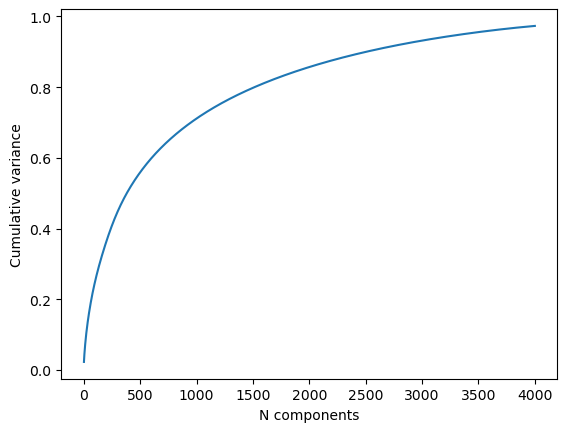

In [29]:
# Truncated SVD
svd = TruncatedSVD(n_components=4000, random_state=42)

# Fit transform
X_train_reduced = svd.fit_transform(X_train_one_hot)

# Explained variance
variance_ratio = svd.explained_variance_ratio_
cumulative_variance = variance_ratio.cumsum()
plt.plot(range(1,len(cumulative_variance)+1), cumulative_variance)
plt.xlabel('N components')
plt.ylabel('Cumulative variance')

In [ ]:
# Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score

models = {
    "LogisticRegression": LogisticRegression(
        random_state=0, penalty='l1', solver='liblinear'
    ),
    "RandomForest": RandomForestClassifier(
        random_state=0, n_jobs=N_CORES
    )
}
param_grids = {
    "LogisticRegression": {"C": [0.05,0.1,0.5,1.]},
    "RandomForest": {'n_estimators': [10,25],
                        'max_depth': [5,10],
                        'min_samples_split': [5,10]}
}
cv = KFold(n_splits=5, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        scoring = make_scorer(f1_score),
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
        verbose=2
    ).fit(X_train_reduced, y_train)
    results_ = {"model": name,
              "cv_results": pd.DataFrame(grid_search.cv_results_),
              "grid_search": grid_search}
    results.append(results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.05; total time=   2.1s
[CV] END .............................................C=0.05; total time=   2.2s
[CV] END .............................................C=0.05; total time=   2.1s
[CV] END .............................................C=0.05; total time=   2.1s
[CV] END .............................................C=0.05; total time=   2.1s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.3s
[CV] END ..............................................C=0.1; total time=   2.3s
[CV] END ..............................................C=0.1; total time=   2.3s
[CV] END ..............................................C=0.1; total time=   2.3s
[CV] END ..............................................C=0.5; total time=   3.2s
[CV] END ........................................

In [32]:
# Display the results
for i,results_ in enumerate(results):
    print(results_['model'],', index:',i)
    cv_results_ = results_['cv_results']
    rank1_cv_results_ = pd.DataFrame(cv_results_[cv_results_['rank_test_score']==1])[
        ["params","mean_test_score","std_test_score","mean_train_score","std_train_score"]]
    display(rank1_cv_results_)

LogisticRegression , index: 0


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
3,{'C': 1.0},0.745215,0.010668,0.889372,0.003328


RandomForest , index: 1


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
7,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.587338,0.02335,0.910378,0.007089


Accuracy: 0.79
Precision: 0.80
Recall: 0.67
F1-Score: 0.73


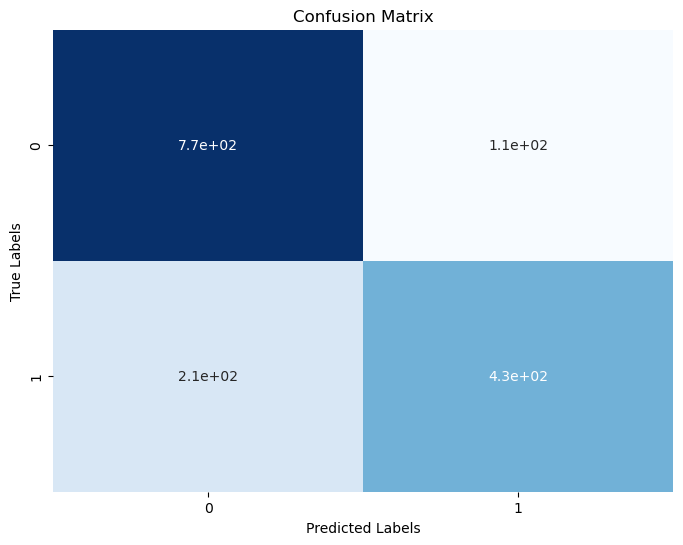

In [34]:
# Evaluate validation set

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Transform
text_one_hot = vectorizer_text.transform(X_val['text_preprocessed_lemm'].apply(' '.join))
keyword_one_hot = vectorizer_keyword.transform(X_val['keyword_preprocessed_lemm'].apply(' '.join))
location_one_hot = vectorizer_location.transform(X_val['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_val_one_hot = hstack([text_one_hot, keyword_one_hot, location_one_hot])

# SVD
X_val_reduced = svd.transform(X_val_one_hot)

# Predict
best_model = results[0]['grid_search'].best_estimator_
y_pred_val = best_model.predict(X_val_reduced)

# Print metrics
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_val)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_val)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_val)
print(f'F1-Score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

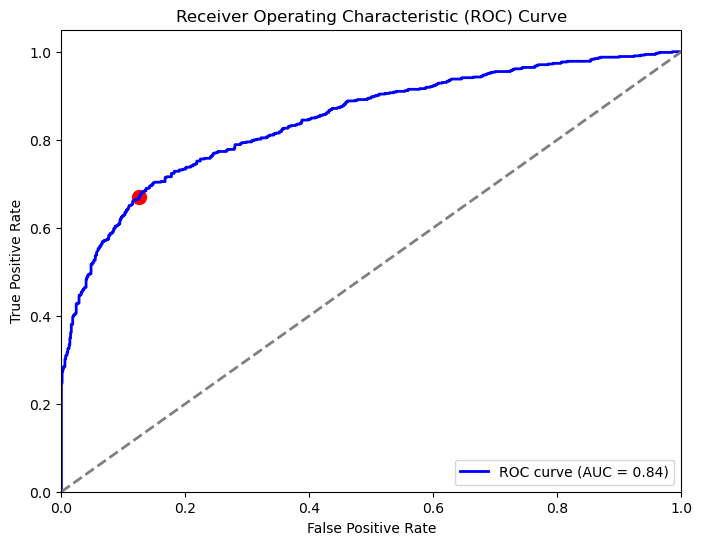

In [44]:
from sklearn.metrics import roc_curve, auc

y_proba_val = best_model.predict_proba(X_val_reduced)[:,1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val)
thres = np.where(thresholds<0.5)[0][0]

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.scatter(fpr[thres],tpr[thres],c='r',s=100)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [58]:
# Predict test set

# Transform
text_one_hot = vectorizer_text.transform(X_test['text_preprocessed_lemm'].apply(' '.join))
keyword_one_hot = vectorizer_keyword.transform(X_test['keyword_preprocessed_lemm'].apply(' '.join))
location_one_hot = vectorizer_location.transform(X_test['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_test_one_hot = hstack([text_one_hot, keyword_one_hot, location_one_hot])

# SVD
X_test_reduced = svd.transform(X_test_one_hot)

# Predict
y_pred_test = best_model.predict(X_test_reduced)

# Put into df
submission_df = pd.DataFrame({"id": test_ids, "target":y_pred_test})
display(submission_df.head(1))

# Save 
submission_df.to_csv(f"{SUBMISSION_PATH}onehot.csv",index=False)

,id,target
0,0,1


Kaggle test set score: 0.78884

## <a id='toc1_5_'></a>[Bag of Words](#toc0_)

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

In [60]:
# Select preprocessed columns
preprocessed_lem_cols = ["text_preprocessed_lemm","keyword_preprocessed_lemm","location_preprocessed_lemm"]
X_train[preprocessed_lem_cols].head()

,text_preprocessed_lemm,keyword_preprocessed_lemm,location_preprocessed_lemm
6383,"[old, pkk, suicide, bomber, detonated, bomb, t...","[suicide, bomb]",[]
1189,"[two, crane, restoring, bridge, central, dutch...","[bridge, collapse]",[]
6288,"[happy, birthday, miss, much, amp, hope, great...",[storm],"[desert, storm]"
4546,"[michaelgbaron, come, scott, rice, get, anothe...",[injured],[]
6847,"[nissannews, trauma, alert, child, among, hosp...",[trauma],"[detroit, mi]"


In [61]:
# We use separate vectorizers for our features
vectorizer_text = CountVectorizer(binary=False)
vectorizer_keyword = CountVectorizer(binary=False)
vectorizer_location = CountVectorizer(binary=False)

# Fit transform
text_bow = vectorizer_text.fit_transform(X_train['text_preprocessed_lemm'].apply(' '.join))
keyword_bow = vectorizer_keyword.fit_transform(X_train['keyword_preprocessed_lemm'].apply(' '.join))
location_bow = vectorizer_location.fit_transform(X_train['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_train_bow = hstack([text_bow, keyword_bow, location_bow])

In [62]:
import joblib

# Print cores
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")
print(f"Number of samples: {df_train.shape[0]}")

# Print shapes
print(X_train_bow.shape,y_train.shape)

Number of physical cores: 4
Number of samples: 7613
(6090, 14489) (6090,)


Text(0, 0.5, 'Cumulative variance')

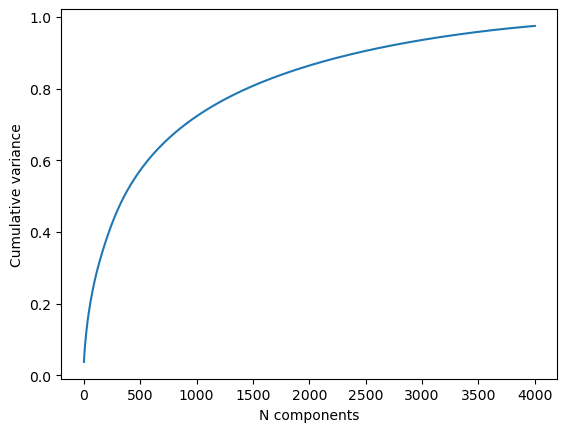

In [63]:
# Truncated SVD
svd = TruncatedSVD(n_components=4000, random_state=42)

# Fit transform
X_train_reduced = svd.fit_transform(X_train_bow)

# Explained variance
variance_ratio = svd.explained_variance_ratio_
cumulative_variance = variance_ratio.cumsum()
plt.plot(range(1,len(cumulative_variance)+1), cumulative_variance)
plt.xlabel('N components')
plt.ylabel('Cumulative variance')

In [ ]:
# Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score

models = {
    "LogisticRegression": LogisticRegression(
        random_state=0, penalty='l1', solver='liblinear'
    ),
    "RandomForest": RandomForestClassifier(
        random_state=0, n_jobs=N_CORES
    )
}
param_grids = {
    "LogisticRegression": {"C": [0.05,0.1,0.5,1.]},
    "RandomForest": {'n_estimators': [10,25,50],
                        'max_depth': [5,10,None],
                        'min_samples_split': [5,10]}
}
cv = KFold(n_splits=5, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        scoring = make_scorer(f1_score),
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
        verbose=2
    ).fit(X_train_reduced, y_train)
    results_ = {"model": name,
              "cv_results": pd.DataFrame(grid_search.cv_results_),
              "grid_search": grid_search}
    results.append(results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.05; total time=   2.4s
[CV] END .............................................C=0.05; total time=   2.2s
[CV] END .............................................C=0.05; total time=   2.2s
[CV] END .............................................C=0.05; total time=   2.3s
[CV] END .............................................C=0.05; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ..............................................C=0.1; total time=   2.3s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.1s
[CV] END ..............................................C=0.5; total time=   3.1s
[CV] END ........................................

In [65]:
# Display the results
for i,results_ in enumerate(results):
    print(results_['model'],', index:',i)
    cv_results_ = results_['cv_results']
    rank1_cv_results_ = pd.DataFrame(cv_results_[cv_results_['rank_test_score']==1])[
        ["params","mean_test_score","std_test_score","mean_train_score","std_train_score"]]
    display(rank1_cv_results_)

LogisticRegression , index: 0


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
2,{'C': 0.5},0.739936,0.011785,0.816747,0.003498


RandomForest , index: 1


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
17,"{'max_depth': None, 'min_samples_split': 10, '...",0.610037,0.017726,0.991973,0.000412


Accuracy: 0.79
Precision: 0.80
Recall: 0.66
F1-Score: 0.72


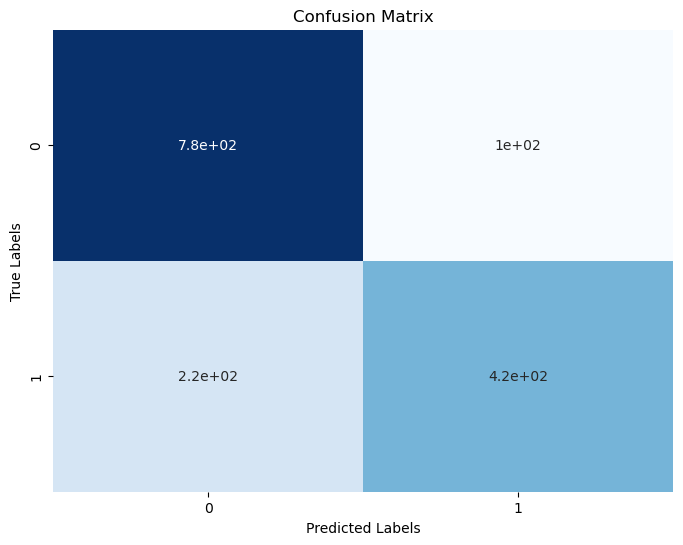

In [66]:
# Evaluate validation set

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Transform
text_bow = vectorizer_text.transform(X_val['text_preprocessed_lemm'].apply(' '.join))
keyword_bow = vectorizer_keyword.transform(X_val['keyword_preprocessed_lemm'].apply(' '.join))
location_bow = vectorizer_location.transform(X_val['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_val_bow = hstack([text_bow, keyword_bow, location_bow])

# SVD
X_val_reduced = svd.transform(X_val_bow)

# Predict
best_model = results[0]['grid_search'].best_estimator_
y_pred_val = best_model.predict(X_val_reduced)

# Print metrics
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_val)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_val)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_val)
print(f'F1-Score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

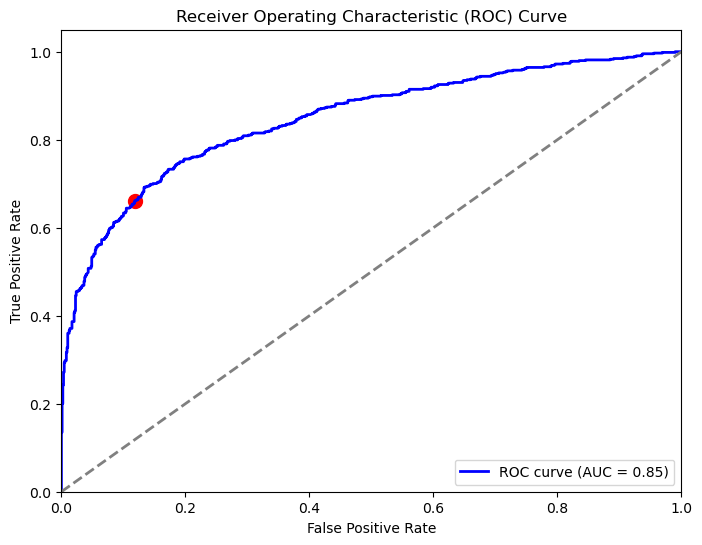

In [67]:
from sklearn.metrics import roc_curve, auc

y_proba_val = best_model.predict_proba(X_val_reduced)[:,1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val)
thres = np.where(thresholds<0.5)[0][0]

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.scatter(fpr[thres],tpr[thres],c='r',s=100)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [68]:
# Predict test set

# Transform
text_bow = vectorizer_text.transform(X_test['text_preprocessed_lemm'].apply(' '.join))
keyword_bow = vectorizer_keyword.transform(X_test['keyword_preprocessed_lemm'].apply(' '.join))
location_bow = vectorizer_location.transform(X_test['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_test_bow = hstack([text_bow, keyword_bow, location_bow])

# SVD
X_test_reduced = svd.transform(X_test_bow)

# Predict
y_pred_test = best_model.predict(X_test_reduced)

# Put into df
submission_df = pd.DataFrame({"id": test_ids, "target":y_pred_test})
display(submission_df.head(1))

# Save 
submission_df.to_csv(f"{SUBMISSION_PATH}bow.csv",index=False)

,id,target
0,0,1


Kaggle test set score: 0.79344

## <a id='toc1_6_'></a>[TF-IDF](#toc0_)

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

In [72]:
# Select preprocessed columns
preprocessed_lem_cols = ["text_preprocessed_lemm","keyword_preprocessed_lemm","location_preprocessed_lemm"]
X_train[preprocessed_lem_cols].head()

,text_preprocessed_lemm,keyword_preprocessed_lemm,location_preprocessed_lemm
6383,"[old, pkk, suicide, bomber, detonated, bomb, t...","[suicide, bomb]",[]
1189,"[two, crane, restoring, bridge, central, dutch...","[bridge, collapse]",[]
6288,"[happy, birthday, miss, much, amp, hope, great...",[storm],"[desert, storm]"
4546,"[michaelgbaron, come, scott, rice, get, anothe...",[injured],[]
6847,"[nissannews, trauma, alert, child, among, hosp...",[trauma],"[detroit, mi]"


In [73]:
# We use separate vectorizers for our features
vectorizer_text = TfidfVectorizer(binary=False)
vectorizer_keyword = TfidfVectorizer(binary=False)
vectorizer_location = TfidfVectorizer(binary=False)

# Fit transform
text_tfidf = vectorizer_text.fit_transform(X_train['text_preprocessed_lemm'].apply(' '.join))
keyword_tfidf = vectorizer_keyword.fit_transform(X_train['keyword_preprocessed_lemm'].apply(' '.join))
location_tfidf = vectorizer_location.fit_transform(X_train['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_train_tfidf = hstack([text_tfidf, keyword_tfidf, location_tfidf])

In [74]:
import joblib

# Print cores
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")
print(f"Number of samples: {df_train.shape[0]}")

# Print shapes
print(X_train_tfidf.shape,y_train.shape)

Number of physical cores: 4
Number of samples: 7613
(6090, 14489) (6090,)


Text(0, 0.5, 'Cumulative variance')

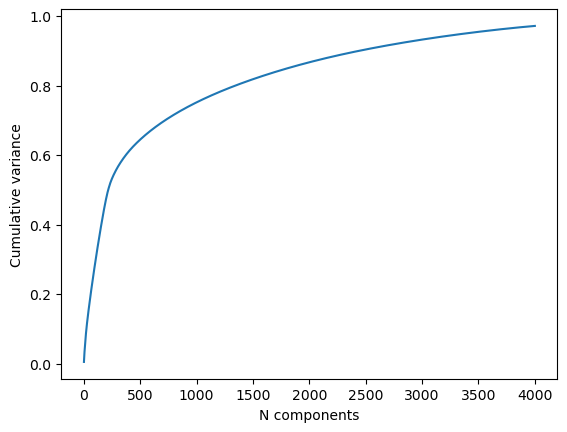

In [75]:
# Truncated SVD
svd = TruncatedSVD(n_components=4000, random_state=42)

# Fit transform
X_train_reduced = svd.fit_transform(X_train_tfidf)

# Explained variance
variance_ratio = svd.explained_variance_ratio_
cumulative_variance = variance_ratio.cumsum()
plt.plot(range(1,len(cumulative_variance)+1), cumulative_variance)
plt.xlabel('N components')
plt.ylabel('Cumulative variance')

In [ ]:
# Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score

models = {
    "LogisticRegression": LogisticRegression(
        random_state=0, penalty='l1', solver='liblinear'
    ),
    "RandomForest": RandomForestClassifier(
        random_state=0, n_jobs=N_CORES
    )
}
param_grids = {
    "LogisticRegression": {"C": [0.05,0.1,0.5,1.]},
    "RandomForest": {'n_estimators': [10,25],
                        'max_depth': [5,10],
                        'min_samples_split': [5,10]}
}
cv = KFold(n_splits=5, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        scoring = make_scorer(f1_score),
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
        verbose=2
    ).fit(X_train_reduced, y_train)
    results_ = {"model": name,
              "cv_results": pd.DataFrame(grid_search.cv_results_),
              "grid_search": grid_search}
    results.append(results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.05; total time=   2.2s
[CV] END .............................................C=0.05; total time=   2.3s
[CV] END .............................................C=0.05; total time=   2.3s
[CV] END .............................................C=0.05; total time=   2.4s
[CV] END .............................................C=0.05; total time=   2.1s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ..............................................C=0.1; total time=   2.5s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ..............................................C=0.5; total time=   2.7s
[CV] END ........................................

In [77]:
# Display the results
for i,results_ in enumerate(results):
    print(results_['model'],', index:',i)
    cv_results_ = results_['cv_results']
    rank1_cv_results_ = pd.DataFrame(cv_results_[cv_results_['rank_test_score']==1])[
        ["params","mean_test_score","std_test_score","mean_train_score","std_train_score"]]
    display(rank1_cv_results_)

LogisticRegression , index: 0


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
3,{'C': 1.0},0.73827,0.008315,0.799709,0.004511


RandomForest , index: 1


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
7,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.56908,0.011906,0.926648,0.002299


Accuracy: 0.78
Precision: 0.76
Recall: 0.69
F1-Score: 0.72


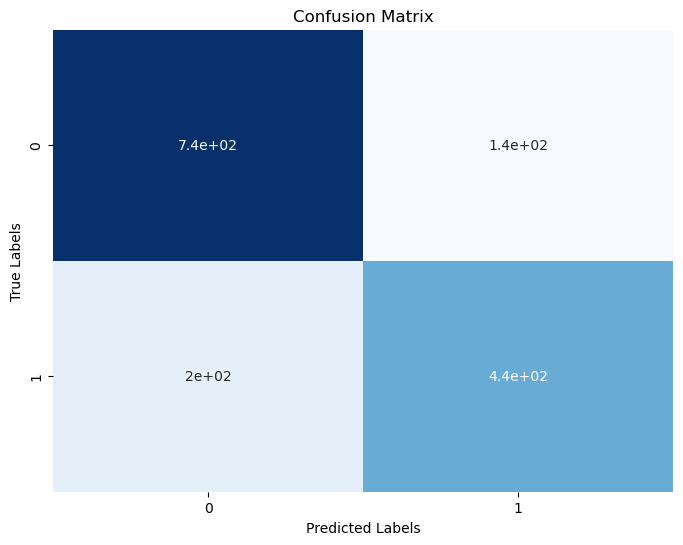

In [78]:
# Evaluate validation set

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Transform
text_tfidf = vectorizer_text.transform(X_val['text_preprocessed_lemm'].apply(' '.join))
keyword_tfidf = vectorizer_keyword.transform(X_val['keyword_preprocessed_lemm'].apply(' '.join))
location_tfidf = vectorizer_location.transform(X_val['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_val_tfidf = hstack([text_tfidf, keyword_tfidf, location_tfidf])

# SVD
X_val_reduced = svd.transform(X_val_tfidf)

# Predict
best_model = results[0]['grid_search'].best_estimator_
y_pred_val = best_model.predict(X_val_reduced)

# Print metrics
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_val)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_val)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_val)
print(f'F1-Score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

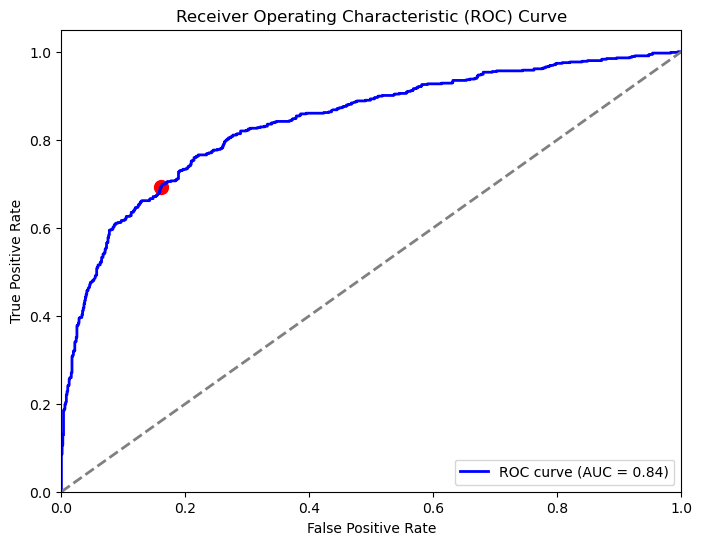

In [79]:
from sklearn.metrics import roc_curve, auc

y_proba_val = best_model.predict_proba(X_val_reduced)[:,1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val)
thres = np.where(thresholds<0.5)[0][0]

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.scatter(fpr[thres],tpr[thres],c='r',s=100)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [80]:
# Predict test set

# Transform
text_tfidf = vectorizer_text.transform(X_test['text_preprocessed_lemm'].apply(' '.join))
keyword_tfidf = vectorizer_keyword.transform(X_test['keyword_preprocessed_lemm'].apply(' '.join))
location_tfidf = vectorizer_location.transform(X_test['location_preprocessed_lemm'].apply(' '.join))

# Combine the matrices horizontally
X_test_tfidf = hstack([text_tfidf, keyword_tfidf, location_tfidf])

# SVD
X_test_reduced = svd.transform(X_test_tfidf)

# Predict
y_pred_test = best_model.predict(X_test_reduced)

# Put into df
submission_df = pd.DataFrame({"id": test_ids, "target":y_pred_test})
display(submission_df.head(1))

# Save 
submission_df.to_csv(f"{SUBMISSION_PATH}tfidf.csv",index=False)

,id,target
0,0,1


Kaggle test set score: 0.78087

## <a id='toc1_7_'></a>[Word2Vec](#toc0_)

We download the vector mapping $\textit{glove-twitter-200}$, trained on twitter data, which possiblly is representative of a similar corpus and vocabulary to ours.

In [70]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from scipy.sparse import hstack
import joblib

# Print cores
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

# Print package versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Gensim version: {gensim.__version__}")

# Select preprocessed columns
preprocessed_lem_cols = ["text_preprocessed_lemm","keyword_preprocessed_lemm","location_preprocessed_lemm"]
X_train[preprocessed_lem_cols].head(1)

Number of physical cores: 4
NumPy version: 1.26.4
Pandas version: 1.4.2
Gensim version: 4.3.3


,text_preprocessed_lemm,keyword_preprocessed_lemm,location_preprocessed_lemm
6383,"[old, pkk, suicide, bomber, detonated, bomb, t...","[suicide, bomb]",[]


In [ ]:
# Download the "glove-twitter-200" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-200')
print("downloaded vectors")

# Save the model
glove_vectors.save("models/glove-twitter-200.kv")

[==================================================] 100.0% 758.5/758.5MB downloaded
downloaded vectors


In [71]:
# Load the model
w2v_model = KeyedVectors.load("models/glove-twitter-200.kv")

# Example
example = w2v_model["disaster"]
print(len(example))
print(len(w2v_model))

example_key = X_train["text_preprocessed_lemm"].iloc[0][0]
if example_key in w2v_model:
    print(len(w2v_model[example_key]))

200
1193514
200


In [ ]:
# Print the fraction of missing words in the model
def count_missing_words(dataset=X_train[preprocessed_lem_cols],w2v_model=w2v_model):
    """Count the number of missing words in the w2v word vectors set."""
    missing=0
    count=0
    for col in dataset.columns:
        for sent in dataset[col]:
            for w in sent:
                if w not in w2v_model:
                    missing+=1
                count+=1
    return missing/count, count

print("Fraction of missing words and sample size:", count_missing_words())

Fraction of missing words and sample size: (0.045481099411538405, 70183)


In [74]:
def get_mean_embedding(words, w2v_model=w2v_model):
    """Get the mean word vector for a list of words"""
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)  # Handle unknown words

def get_embedded_dataset(X_train):
    """Embded the passed dataframe and return numpy array"""
    # Get mean embedding per each column    
    text_embedded = np.stack(
        X_train["text_preprocessed_lemm"].apply(get_mean_embedding).values)
    keyword_embedded = np.stack(
        X_train["keyword_preprocessed_lemm"].apply(get_mean_embedding).values)
    location_embedded = np.stack(
        X_train["location_preprocessed_lemm"].apply(get_mean_embedding).values)
    # Stack
    X_train_w2v = np.hstack([text_embedded,keyword_embedded,location_embedded])
    return X_train_w2v

X_train_w2v = get_embedded_dataset(X_train)
print("Train data shape:", X_train_w2v.shape)
print("Train labels shape:", y_train.shape)

Train data shape: (6090, 600)
Train labels shape: (6090,)


In [ ]:
# Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score

models = {
    "LogisticRegressionL1": LogisticRegression(
        random_state=0, penalty='l1', solver='liblinear'
    ),
    "LogisticRegressionL2": LogisticRegression(
        random_state=0, penalty='l2', solver='liblinear'
    ),
    "RandomForest": RandomForestClassifier(
        random_state=0, n_jobs=N_CORES
    )
}
param_grids = {
    "LogisticRegressionL1": {"C": [0.05,0.1,0.5,1.]},
    "LogisticRegressionL2": {"C": [0.05,0.1,0.5,1.]},
    "RandomForest": {'n_estimators': [50,100],
                        'max_depth': [5,None],
                        'min_samples_split': [5,10]}
}
cv = KFold(n_splits=5, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        scoring = make_scorer(f1_score),
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
        verbose=2
    ).fit(X_train_w2v, y_train)
    results_ = {"model": name,
              "cv_results": pd.DataFrame(grid_search.cv_results_),
              "grid_search": grid_search}
    results.append(results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.05; total time=   0.3s
[CV] END .............................................C=0.05; total time=   0.4s
[CV] END .............................................C=0.05; total time=   0.3s
[CV] END .............................................C=0.05; total time=   0.4s
[CV] END .............................................C=0.05; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   1.0s
[CV] END ..............................................C=0.1; total time=   0.8s
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.5; total time=   3.0s
[CV] END ........................................

In [76]:
# Display the results
for i,results_ in enumerate(results):
    print(results_['model'],', index:',i)
    cv_results_ = results_['cv_results']
    rank1_cv_results_ = pd.DataFrame(cv_results_[cv_results_['rank_test_score']==1])[
        ["params","mean_test_score","std_test_score","mean_train_score","std_train_score"]]
    display(rank1_cv_results_)

LogisticRegressionL1 , index: 0


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
2,{'C': 0.5},0.753346,0.017132,0.802432,0.004214


LogisticRegressionL2 , index: 1


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,{'C': 0.05},0.757222,0.013788,0.793785,0.002555


RandomForest , index: 2


,params,mean_test_score,std_test_score,mean_train_score,std_train_score
3,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.762343,0.011857,0.947248,0.002576


In [78]:
# RF clf is overfitting. Let's try a more comprehensive search over a suited parameter space using BayesSearchCV.

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.ensemble import RandomForestClassifier

param_space = {
    'n_estimators': Categorical([50, 100, 150, 200, 500]),
    'max_depth': Categorical([5, 10, 15, 20, 30]),
    'min_samples_split': Categorical([10, 20, 30, 40]),
    'min_samples_leaf': Categorical([2, 5, 10, 20])
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=N_CORES)

cv = KFold(n_splits=5, shuffle=True, random_state=0)

bayes_search = BayesSearchCV(
    estimator=rf_clf, 
    search_spaces=param_space, 
    n_iter=25, 
    n_jobs=N_CORES, 
    cv=cv, 
    scoring=make_scorer(f1_score), 
    random_state=0,
    verbose=2
)

bayes_search.fit(X_train_w2v,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=30, n_estimators=200; total time=   6.5s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=30, n_estimators=200; total time=   7.1s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=30, n_estimators=200; total time=   7.1s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=30, n_estimators=200; total time=   7.3s
[CV] END max_depth=15, min_samples_leaf=10, min_samples_split=30, n_estimators=200; total time=   3.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=40, n_estimators=150; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=40, n_estimators=150; total time=   4.8s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=40, n_estimators=150; total time=   4.9s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=40, n_estimators=150; total time=   5.2s
[CV] END max_d

BayesSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
              estimator=RandomForestClassifier(n_jobs=4, random_state=0),
              n_iter=25, n_jobs=4, random_state=0,
              scoring=make_scorer(f1_score),
              search_spaces={'max_depth': Categorical(categories=(5, 10, 15, 20, 30), prior=None),
                             'min_samples_leaf': Categorical(categories=(2, 5, 10, 20), prior=None),
                             'min_samples_split': Categorical(categories=(10, 20, 30, 40), prior=None),
                             'n_estimators': Categorical(categories=(50, 100, 150, 200, 500), prior=None)},
              verbose=2)

In [81]:
# Display results
bs_results_ = pd.DataFrame(bayes_search.cv_results_)
display(bs_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.132078,1.530669,0.120406,0.058614,15,10,30,200,"{'max_depth': 15, 'min_samples_leaf': 10, 'min...",0.750515,0.743041,0.771242,0.766902,0.748373,0.756015,0.011021,17
1,4.203941,1.138316,0.097213,0.023791,10,20,40,150,"{'max_depth': 10, 'min_samples_leaf': 20, 'min...",0.756148,0.734341,0.764387,0.761523,0.754063,0.754092,0.010541,18
2,2.169965,0.570493,0.042729,0.017805,15,2,20,50,"{'max_depth': 15, 'min_samples_leaf': 2, 'min_...",0.769074,0.732841,0.776931,0.756269,0.749727,0.756968,0.015363,13
3,3.324621,0.878340,0.077511,0.025455,5,20,20,150,"{'max_depth': 5, 'min_samples_leaf': 20, 'min_...",0.732919,0.733690,0.757872,0.737487,0.730643,0.738522,0.009923,23
4,3.748824,0.903504,0.065974,0.018707,10,2,30,100,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.759674,0.735608,0.776699,0.760396,0.755940,0.757663,0.013140,9
5,5.189692,1.509144,0.090716,0.034758,30,20,30,150,"{'max_depth': 30, 'min_samples_leaf': 20, 'min...",0.757981,0.729817,0.780172,0.764113,0.749729,0.756363,0.016603,15
6,1.735706,0.519952,0.025734,0.005158,30,20,20,50,"{'max_depth': 30, 'min_samples_leaf': 20, 'min...",0.744090,0.735608,0.764387,0.758621,0.738562,0.748253,0.011304,20
7,2.066738,0.544431,0.046526,0.014457,15,10,30,50,"{'max_depth': 15, 'min_samples_leaf': 10, 'min...",0.751540,0.741139,0.771892,0.758759,0.747014,0.754069,0.010611,19
8,13.567722,3.753766,0.286650,0.094416,5,20,40,500,"{'max_depth': 5, 'min_samples_leaf': 20, 'min_...",0.739444,0.730811,0.753529,0.737271,0.734873,0.739186,0.007723,22
9,9.974462,2.948456,0.135537,0.043492,10,5,20,200,"{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.758974,0.738854,0.780541,0.766169,0.754881,0.759884,0.013670,1


In [84]:
bayes_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
                       n_estimators=200, n_jobs=4, random_state=0)

Val set shape: (1523, 600)
Accuracy: 0.78
Precision: 0.76
Recall: 0.69
F1-Score: 0.73


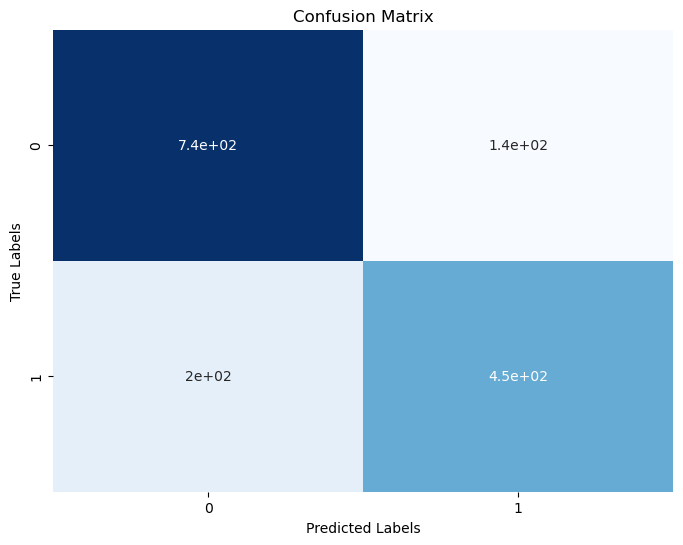

In [ ]:
# Evaluate validation set

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Transform
X_val_w2v = get_embedded_dataset(X_val)
print("Val set shape:", X_val_w2v.shape)

# Predict
best_model = results[0]['grid_search'].best_estimator_ # We'll go with the L1 logreg again
y_pred_val = best_model.predict(X_val_w2v)

# Print metrics
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_val)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_val)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_val)
print(f'F1-Score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [87]:
# Predict test set

# Transform
X_test_w2v = get_embedded_dataset(X_test)
print("Val set shape:", X_test_w2v.shape)

# Predict
y_pred_test = best_model.predict(X_test_w2v)

# Put into df
submission_df = pd.DataFrame({"id": test_ids, "target":y_pred_test})
display(submission_df.head(1))

# Save 
submission_df.to_csv(f"{SUBMISSION_PATH}w2v.csv",index=False)

Val set shape: (3263, 600)


,id,target
0,0,1


Kaggle test set score: 0.77536